In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
from math import sqrt
import statsmodels.api as sm

from operator import itemgetter
from itertools import combinations

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
import scipy


from tqdm import tqdm

import xgboost as xgb

from itertools import combinations
from pandas.plotting import scatter_matrix

from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from pprint import pprint


from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

import warnings

#import other python files

In [2]:
#technical calculations for preprocessing the pandas dataframes

def calc_overload (load_P, load_factor):
    '''Calculates the potential overload of a grid resource.
    Returns the overload power in MW
    param: load_P
    param: load_factor
    return: overload_P'''
    capacity = abs(load_P)/(load_factor/100)
    overload_P = load_P - capacity if load_P > capacity else 0
    return overload_P

def calc_gen_capacity (load_P, load_factor):
    '''Calculates the generation capacity for a generating grid resource.
    Returns the generation power in MW
    param: load_P
    param: load_factor
    return: gen_capacity_P'''
    capacity = load_P/(load_factor/100)
    gen_capacity_P = abs(capacity) if capacity < 0 else 0
    return gen_capacity_P

def calc_gen_overload (load_P, gen_capacity_P):
    '''Calculates the generation overload for a generating grid resource.
    Returns the generation power in MW
    param: load_P
    param: load_factor
    return: gen_overload_P'''
    gen_overload_P = abs(load_P) - gen_capacity_P if load_P < 0 and abs(load_P) > gen_capacity_P else 0
    return gen_overload_P


In [21]:
df_emob=pd.read_csv(r"C:\Users\laumen\Time Series Clustering\Datasets\3544_9/EMob_Zeitreihe_nnf_1h.csv",
                    sep = ';',
                    engine='python',
                    encoding='latin-1',
                    skiprows = 2)
df_emob['sum_emob']=df_emob.drop('NNF',axis=1).sum(axis=1)


df_pv=pd.read_csv(r"C:\Users\laumen\Time Series Clustering\Datasets\3544_9/PV_Zeitreihe_nnf_1h.csv",
                    sep = ';',
                    engine='python',
                    encoding='latin-1',
                    skiprows = 2)
df_pv['sum_pv']=df_pv.drop('NNF',axis=1).sum(axis=1)


df_wea=pd.read_csv(r"C:\Users\laumen\Time Series Clustering\Datasets\3544_9/WEA_nnf_1h.csv",
                    sep = ';',
                    engine='python',
                    encoding='latin-1',
                    skiprows = 2)
df_wea['sum_wea']=df_wea.drop('NNF',axis=1).sum(axis=1)


df_wp=pd.read_csv(r"C:\Users\laumen\Time Series Clustering\Datasets\3544_9/WP_Zeitreihe_nnf.csv",
                    sep = ';',
                    engine='python',
                    encoding='latin-1',
                    skiprows = 2)
df_wp['sum_wp']=df_wp.drop('NNF',axis=1).sum(axis=1)

#Concat dataframe with all input information
df_input=pd.concat([df_emob["NNF"],df_emob["sum_emob"],df_pv['sum_pv'],df_wea['sum_wea'],df_wp['sum_wp']],axis=1, keys=['NNF','sum_emob','sum_PV','sum_wea','sum_wp'])

#Generate cyclic time encoding
df_input['time'] = pd.Timestamp('2012-01-01')+pd.to_timedelta(df_input['NNF'], unit='H')
df_input['year']=df_input.time.dt.year
df_input['month']=df_input.time.dt.month
df_input['day']=df_input.time.dt.day
df_input['hour']=df_input.time.dt.hour

#set datetime object as index
df_input = df_input.set_index('time')

#create workhour feature
for i in range(len(df_input)):
    position = df_input.index[i]
    
    hour = position.hour
    
    if (hour > 8.9 and hour < 17):
        df_input.loc[position, 'workhour'] = 1
    else:
        df_input.loc[position, 'workhour'] = 0

#create weekend feature
for i in range(len(df_input)):
    position = df_input.index[i]
    
    weekday = position.weekday()
    
    if (weekday == 5 or weekday == 6):
        df_input.loc[position, 'weekday'] = 1 #Weekend
    else:
        df_input.loc[position, 'weekday'] = 0 #weekday
        
        

#rearrange dataframe
df_input = df_input[['NNF','year','month','day','hour','workhour','weekday','sum_emob',
                    'sum_wea','sum_PV','sum_wp']]


df_input

,NNF,year,month,day,hour,workhour,weekday,sum_emob,sum_wea,sum_PV,sum_wp
time,,,,,,,,,,,
2012-01-01 01:00:00,1,2012,1,1,1,0.0,1.0,0.000000,106.618584,0.0,0.0000
2012-01-01 02:00:00,2,2012,1,1,2,0.0,1.0,0.001800,112.597158,0.0,0.1179
2012-01-01 03:00:00,3,2012,1,1,3,0.0,1.0,0.004128,122.462564,0.0,0.2520
2012-01-01 04:00:00,4,2012,1,1,4,0.0,1.0,0.009348,121.245855,0.0,0.3168
2012-01-01 05:00:00,5,2012,1,1,5,0.0,1.0,0.002565,122.035419,0.0,0.2835
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-30 20:00:00,8756,2012,12,30,20,0.0,1.0,0.126809,6.612531,0.0,0.3060
2012-12-30 21:00:00,8757,2012,12,30,21,0.0,1.0,0.123949,6.327013,0.0,0.3159
2012-12-30 22:00:00,8758,2012,12,30,22,0.0,1.0,0.121245,5.917740,0.0,0.1503


In [22]:
# load dataset and safe in pandas dataframe df
df=pd.read_csv(r"C:\Users\laumen\Time Series Clustering\Datasets\erg1/Ausgabe_Zweige.csv",
               sep = ';',
               dtype = {"id": int, "schluessel": str, "typ": str,
                        "bezeichner": str, "und_anf": float, "bez_so_end":str,
                        "un_end":float, "nnf":int, "p_n0_vor": float,
                        "q_n0_vor": float, "ausl_n0_vor": float, "ausl_n1_vor": float,
                        "ausl_n0_nach":float},
               engine='python',
               encoding='latin-1')



df2=pd.read_csv(r"C:\Users\laumen\Time Series Clustering\Datasets\erg2/Ausgabe_Zweige2.csv",
                sep = ';',
                dtype = {"id": int, "schluessel": str, "typ": str,
                        "bezeichner": str, "und_anf": float, "bez_so_end":str,
                        "un_end":float, "nnf":int, "p_n0_vor": float,
                        "q_n0_vor": float, "ausl_n0_vor": float, "ausl_n1_vor": float,
                        "ausl_n0_nach":float},
                engine='python',
                encoding='latin-1')

#print(df)
#print(df2)

#dataframes merge
frames = [df,df2]
df_all = pd.concat(frames, ignore_index=True)
print(df_all)

#drop useless columns
df_all = df_all.drop(['id','bezeichner','kurzname',
                      'bez_so_anf','ukz_so_anf','un_anf',
                      'ngr_anf','bez_so_end','ukz_so_end',
                      'un_end','ngr_end'],axis=1)
print(df_all)



# delete duplicates
#df_all = df_all[df_all.duplicated(subset=['schluessel','nnf'], keep=False)]
#print(df_all.duplicated(subset=['schluessel','nnf'], keep=False))






             id                                     schluessel  \
0           300                   SO-·Standort_0/T2-Trafo_HSMS   
1           305               SO-·Standort_0/T2-Trafo_HSMS_par   
2         33162  L-··L_Knoten_17_Stichabgang_R_Knoten_HSMS_MS·   
3         33014                           L-··Knoten_17_Stich·   
4         33542                                  L-··L_65R_39·   
...         ...                                            ...   
1733455   16324                    SO-·Standort_49/T2-Trafo_49   
1733456   33486                                  L-··L_36R_36·   
1733457    8975                    SO-·Standort_36/T2-Trafo_36   
1733458  108130                             L-··L_0R_36_boost·   
1733459  108381                           L-··L_0R_36_boost_1·   

                        typ                                bezeichner  \
0        Transformator (2W)                                Trafo_HSMS   
1        Transformator (2W)                            Trafo_

In [23]:
#add overload & generation to df
df_all['overload_P'] = df_all.apply(lambda x: calc_overload(x['p_n0_vor'], x['ausl_n0_vor']),axis=1)
df_all['generation_capacity_P'] = df_all.apply(lambda x: calc_gen_capacity(x['p_n0_vor'], x['ausl_n0_vor']),axis=1)
df_all['generation_overaload_P'] = df_all.apply(lambda x: calc_gen_overload(x['p_n0_vor'], x['generation_capacity_P']),axis=1)


df_all

,schluessel,typ,bez_ss_kn_anf,bez_ss_kn_end,nnf,p_n0_vor,q_n0_vor,ausl_n0_vor,ausl_n1_vor,ausl_n0_nach,...,q_n1_vor,q_n0_nach,q_n1_nach,i_n0_vor,i_n1_vor,i_n0_nach,i_n1_nach,overload_P,generation_capacity_P,generation_overaload_P
0,SO-·Standort_0/T2-Trafo_HSMS,Transformator (2W),1,1,1,49.07176,-0.18297,61.42374,0.0,61.42374,...,0,-0.18297,0,2837.04080,0,2837.04080,0,0.0,0.000000,0
1,SO-·Standort_0/T2-Trafo_HSMS_par,Transformator (2W),1,1,1,49.07176,-0.18297,61.42374,0.0,61.42374,...,0,-0.18297,0,2837.04080,0,2837.04080,0,0.0,0.000000,0
2,L-··L_Knoten_17_Stichabgang_R_Knoten_HSMS_MS·,Leitung,1,1,1,2.26782,-0.00470,40.99390,0.0,40.99390,...,0,-0.00470,0,130.77055,0,130.77055,0,0.0,0.000000,0
3,L-··Knoten_17_Stich·,Leitung,1,1,1,-0.49971,-0.00417,9.03328,0.0,9.03328,...,0,-0.00417,0,28.81615,0,28.81615,0,0.0,5.531878,0
4,L-··L_65R_39·,Leitung,1,1,1,2.15125,-0.02347,37.98830,0.0,37.98830,...,0,-0.02347,0,121.18269,0,121.18269,0,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733455,SO-·Standort_49/T2-Trafo_49,Transformator (2W),1,1,8746,0.15452,0.00619,24.49191,0.0,24.49191,...,0,0.00619,0,8.90846,0,8.90846,0,0.0,0.000000,0
1733456,L-··L_36R_36·,Leitung,1,1,8746,0.06870,-0.00461,1.24336,0.0,1.24336,...,0,-0.00461,0,3.96632,0,3.96632,0,0.0,0.000000,0
1733457,SO-·Standort_36/T2-Trafo_36,Transformator (2W),1,1,8746,0.06879,0.00281,27.47913,0.0,27.47913,...,0,0.00281,0,3.96627,0,3.96627,0,0.0,0.000000,0
1733458,L-··L_0R_36_boost·,Leitung,1,1,8746,-0.06825,-0.10819,2.31245,0.0,2.31245,...,0,-0.10819,0,7.37672,0,7.37672,0,0.0,2.951415,0


In [24]:
#aggregate the overload counts
df_list=df_all.groupby('nnf')['overload_P'].sum()
df_small=pd.DataFrame(df_list,columns = ['overload_P'])
df_small['NNF']=df_small.index
df_small['time'] = pd.Timestamp('2012-01-01')+pd.to_timedelta(df_small['NNF'], unit='H')


#set datetime object as index & get rid of NNF again
df_small = df_small.set_index('time').drop(['NNF'],axis=1)


df_small=pd.concat([df_input,df_small['overload_P']], axis=1)
df_small

,NNF,year,month,day,hour,workhour,weekday,sum_emob,sum_wea,sum_PV,sum_wp,overload_P
time,,,,,,,,,,,,
2012-01-01 01:00:00,1,2012,1,1,1,0.0,1.0,0.000000,106.618584,0.0,0.0000,0.000000
2012-01-01 02:00:00,2,2012,1,1,2,0.0,1.0,0.001800,112.597158,0.0,0.1179,0.718811
2012-01-01 03:00:00,3,2012,1,1,3,0.0,1.0,0.004128,122.462564,0.0,0.2520,13.876143
2012-01-01 04:00:00,4,2012,1,1,4,0.0,1.0,0.009348,121.245855,0.0,0.3168,11.773994
2012-01-01 05:00:00,5,2012,1,1,5,0.0,1.0,0.002565,122.035419,0.0,0.2835,12.800512
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-30 20:00:00,8756,2012,12,30,20,0.0,1.0,0.126809,6.612531,0.0,0.3060,0.000000
2012-12-30 21:00:00,8757,2012,12,30,21,0.0,1.0,0.123949,6.327013,0.0,0.3159,0.000000
2012-12-30 22:00:00,8758,2012,12,30,22,0.0,1.0,0.121245,5.917740,0.0,0.1503,0.000000


In [25]:
#aggregate the overload counts per type of grid resource
df_list2=df_all.groupby(['nnf','typ'],as_index=False)['overload_P'].sum()

#print(df_list2)
  
df_small2=pd.DataFrame(df_list2)
df_small2

#create separate dataframes each
df_small_overload_Trafo = df_small2[(df_small2['typ']=='Transformator (2W)')].rename(columns={'overload_P':'Overload_Trafo_P',
                                                                                   'nnf': 'NNF'}).drop(['typ'],axis=1) 
df_small_overload_Leitung = df_small2[(df_small2['typ']=='Leitung')].rename(columns={'overload_P':'Overload_Leitung_P',
                                                                                   'nnf': 'NNF'}).drop(['typ'],axis=1) 

df_small_overload_Trafo['time'] = pd.Timestamp('2012-01-01')+pd.to_timedelta(df_small_overload_Trafo['NNF'], unit='H')
df_small_overload_Leitung['time'] = pd.Timestamp('2012-01-01')+pd.to_timedelta(df_small_overload_Leitung['NNF'], unit='H')

#set datetime object as index & get rid of NNF again
df_small_overload_Trafo = df_small_overload_Trafo.set_index('time').drop(['NNF'],axis=1)
df_small_overload_Leitung = df_small_overload_Leitung.set_index('time').drop(['NNF'],axis=1)


df_small=pd.concat([df_small,df_small_overload_Trafo['Overload_Trafo_P'], df_small_overload_Leitung['Overload_Leitung_P']],axis=1)
df_small


,NNF,year,month,day,hour,workhour,weekday,sum_emob,sum_wea,sum_PV,sum_wp,overload_P,Overload_Trafo_P,Overload_Leitung_P
time,,,,,,,,,,,,,,
2012-01-01 01:00:00,1,2012,1,1,1,0.0,1.0,0.000000,106.618584,0.0,0.0000,0.000000,0.0,0.000000
2012-01-01 02:00:00,2,2012,1,1,2,0.0,1.0,0.001800,112.597158,0.0,0.1179,0.718811,0.0,0.718811
2012-01-01 03:00:00,3,2012,1,1,3,0.0,1.0,0.004128,122.462564,0.0,0.2520,13.876143,0.0,13.876143
2012-01-01 04:00:00,4,2012,1,1,4,0.0,1.0,0.009348,121.245855,0.0,0.3168,11.773994,0.0,11.773994
2012-01-01 05:00:00,5,2012,1,1,5,0.0,1.0,0.002565,122.035419,0.0,0.2835,12.800512,0.0,12.800512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-30 20:00:00,8756,2012,12,30,20,0.0,1.0,0.126809,6.612531,0.0,0.3060,0.000000,0.0,0.000000
2012-12-30 21:00:00,8757,2012,12,30,21,0.0,1.0,0.123949,6.327013,0.0,0.3159,0.000000,0.0,0.000000
2012-12-30 22:00:00,8758,2012,12,30,22,0.0,1.0,0.121245,5.917740,0.0,0.1503,0.000000,0.0,0.000000


In [26]:
#aggregate the average uzilizazion for all
df_list3=df_all.groupby('nnf',as_index=False)['ausl_n0_vor'].mean()
df_small3=pd.DataFrame(df_list3)
df_small3
df_small3['time'] = pd.Timestamp('2012-01-01')+pd.to_timedelta(df_small3['nnf'], unit='H')
df_small3=df_small3.rename(columns={'ausl_n0_vor':'avg_utilization'})  

#set datetime object as index & get rid of NNF again
df_small3 = df_small3.set_index('time').drop(['nnf'],axis=1)


#aggregate average utilization for each type of grid resource
df_list4=df_all.groupby(['nnf','typ'],as_index=False)['ausl_n0_vor'].mean()
df_small4=pd.DataFrame(df_list4)
df_small4=df_small4.rename(columns={'ausl_n0_vor':'avg_utilization'})                   

                           
#create separate dataframes each
df_small_utilization_Trafo = df_small4[(df_small4['typ']=='Transformator (2W)')].rename(columns={'avg_utilization':'avg_utilization_Trafo',
                                                                                   'nnf': 'NNF'}).drop(['typ'],axis=1) 
                                                                                   
df_small_utilization_Leitung = df_small4[(df_small4['typ']=='Leitung')].rename(columns={'avg_utilization':'avg_utilization_Leitung',
                                                                                   'nnf': 'NNF'}).drop(['typ'],axis=1)

df_small_utilization_Trafo['time'] = pd.Timestamp('2012-01-01')+pd.to_timedelta(df_small_utilization_Trafo['NNF'], unit='H')
df_small_utilization_Leitung['time'] = pd.Timestamp('2012-01-01')+pd.to_timedelta(df_small_utilization_Leitung['NNF'], unit='H')

#set datetime object as index & get rid of NNF again
df_small_utilization_Trafo = df_small_utilization_Trafo.set_index('time').drop(['NNF'],axis=1)
df_small_utilization_Leitung = df_small_utilization_Leitung.set_index('time').drop(['NNF'],axis=1)


df_small=pd.concat([df_small,df_small3['avg_utilization'],df_small_utilization_Trafo['avg_utilization_Trafo'], df_small_utilization_Leitung['avg_utilization_Leitung']],axis=1)


#df_small4 
df_small


,NNF,year,month,day,hour,workhour,weekday,sum_emob,sum_wea,sum_PV,sum_wp,overload_P,Overload_Trafo_P,Overload_Leitung_P,avg_utilization,avg_utilization_Trafo,avg_utilization_Leitung
time,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,1,2012,1,1,1,0.0,1.0,0.000000,106.618584,0.0,0.0000,0.000000,0.0,0.000000,32.964284,23.152380,35.793483
2012-01-01 02:00:00,2,2012,1,1,2,0.0,1.0,0.001800,112.597158,0.0,0.1179,0.718811,0.0,0.718811,36.080521,23.390798,39.717210
2012-01-01 03:00:00,3,2012,1,1,3,0.0,1.0,0.004128,122.462564,0.0,0.2520,13.876143,0.0,13.876143,41.097624,22.921458,46.306648
2012-01-01 04:00:00,4,2012,1,1,4,0.0,1.0,0.009348,121.245855,0.0,0.3168,11.773994,0.0,11.773994,40.825983,22.952951,45.979557
2012-01-01 05:00:00,5,2012,1,1,5,0.0,1.0,0.002565,122.035419,0.0,0.2835,12.800512,0.0,12.800512,40.875915,22.192267,46.263224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-30 20:00:00,8756,2012,12,30,20,0.0,1.0,0.126809,6.612531,0.0,0.3060,0.000000,0.0,0.000000,9.108330,27.321132,3.401652
2012-12-30 21:00:00,8757,2012,12,30,21,0.0,1.0,0.123949,6.327013,0.0,0.3159,0.000000,0.0,0.000000,9.214160,27.832871,3.380297
2012-12-30 22:00:00,8758,2012,12,30,22,0.0,1.0,0.121245,5.917740,0.0,0.1503,0.000000,0.0,0.000000,8.819448,26.782794,3.190933


- skalierung
- verteilung
- correlation matrix
- 

<AxesSubplot:>

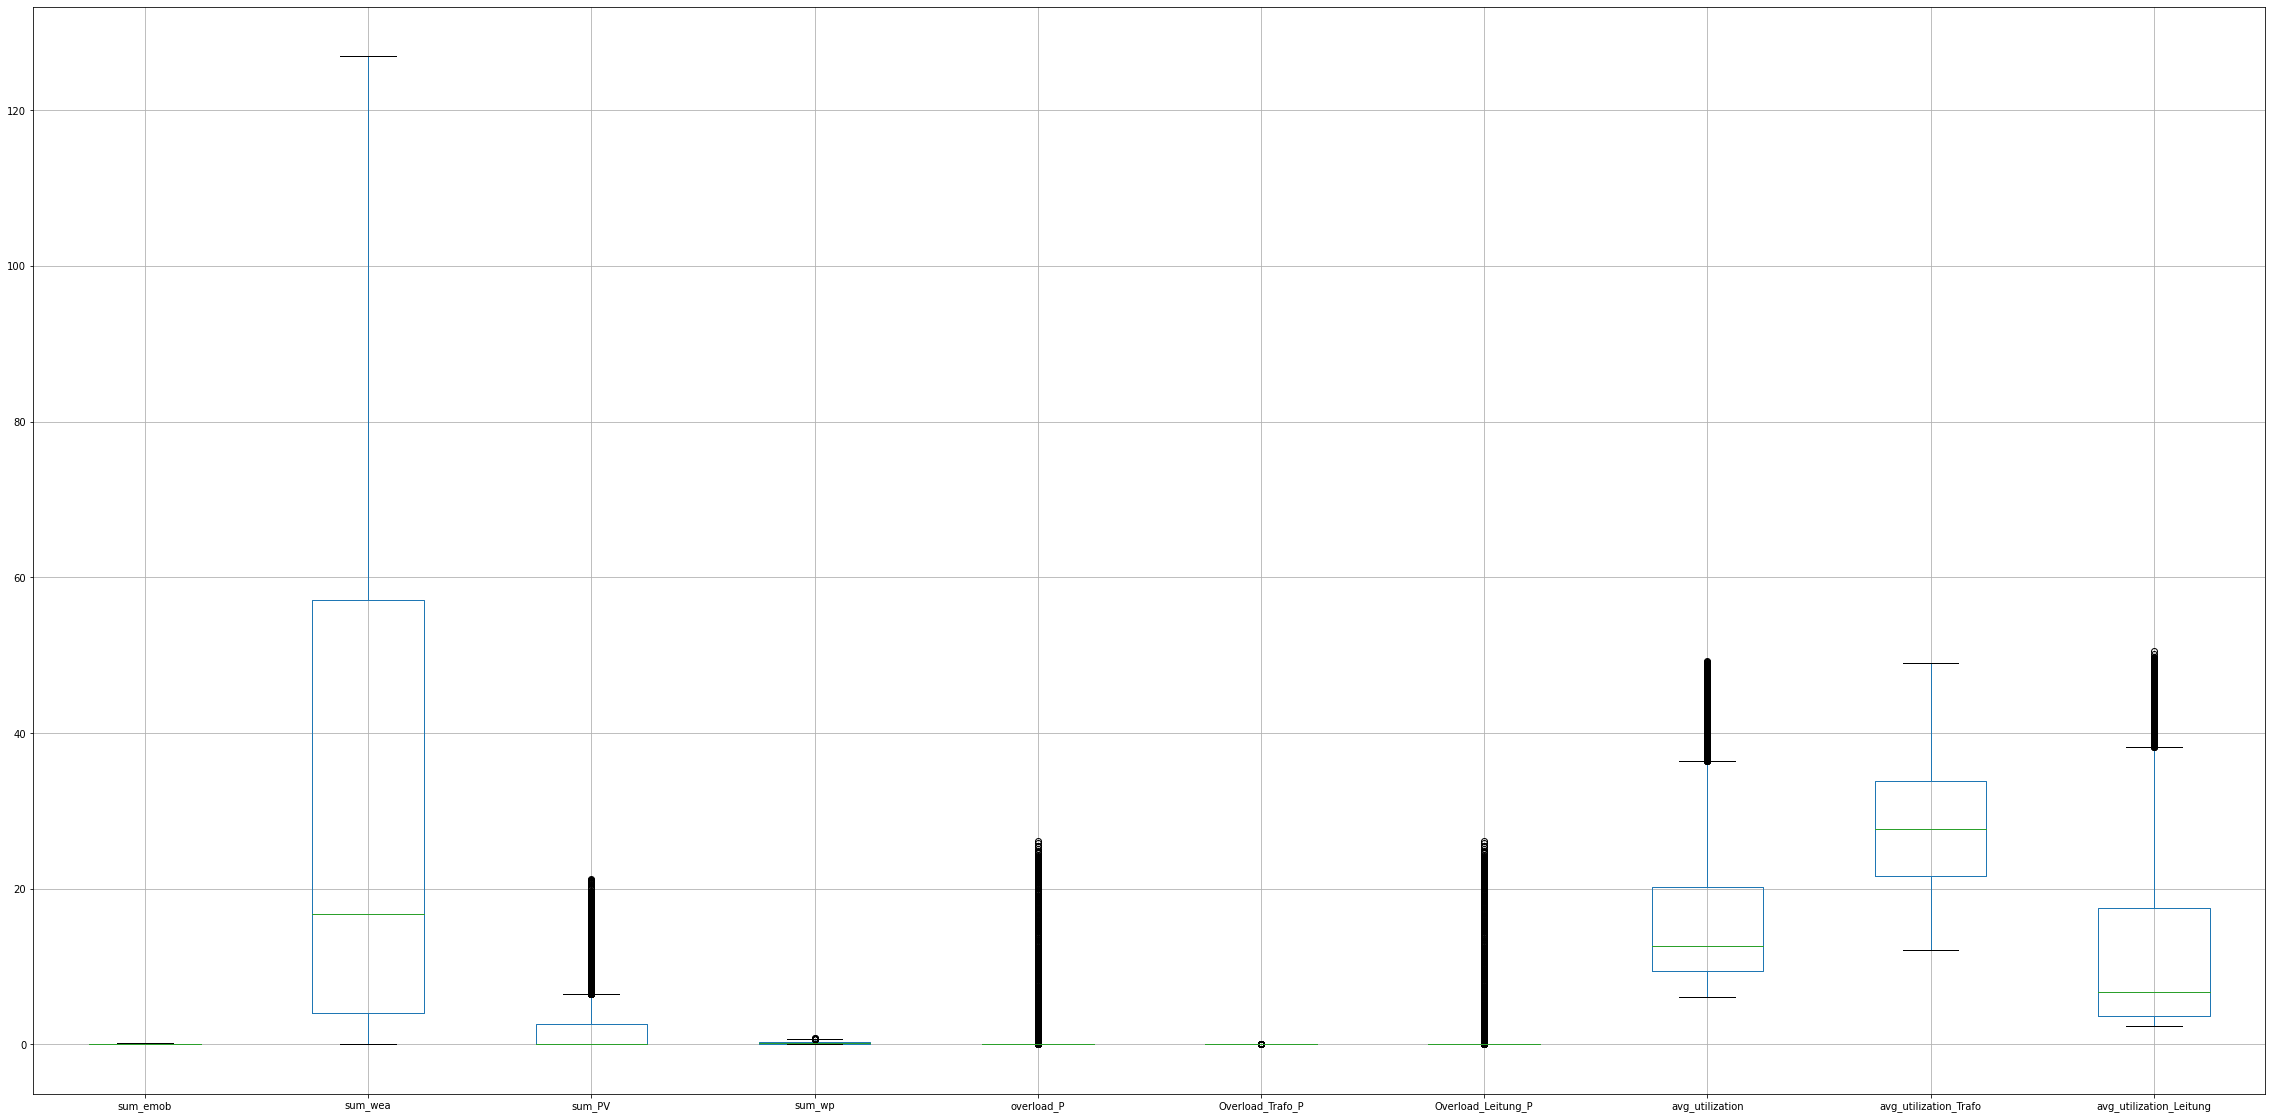

In [27]:
import matplotlib.pyplot as plt
df_small.drop(['NNF','year','month','day','hour','weekday','workhour'],axis=1).boxplot(widths=0.5,
                 figsize=(40,20))

### Feature Importance

#### Correlation analysis


In [99]:
# print correlations for price_actual in the Time series (TS) training set
correlations= df_small.corr(method='pearson')
print(correlations['overload_P'].sort_values(ascending=False).to_string()+"\n")
print(correlations['avg_utilization'].sort_values(ascending=False).to_string())


overload_P                 1.000000
Overload_Leitung_P         0.999999
avg_utilization            0.612756
avg_utilization_Leitung    0.612403
sum_wea                    0.525677
sum_wp                     0.183016
avg_utilization_Trafo      0.166224
workhour                   0.095608
Overload_Trafo_P           0.070072
month                      0.047820
weekday                    0.042771
NNF                        0.039151
hour                       0.015929
sum_emob                   0.002189
sum_PV                    -0.002827
day                       -0.107048
year                            NaN

avg_utilization            1.000000
avg_utilization_Leitung    0.984696
sum_wea                    0.960241
overload_P                 0.612756
Overload_Leitung_P         0.612635
avg_utilization_Trafo      0.430848
workhour                   0.278243
Overload_Trafo_P           0.161398
sum_wp                     0.143751
hour                       0.125401
month                      

,sum_emob,sum_wea,sum_PV,sum_wp,overload_P,Overload_Trafo_P,Overload_Leitung_P,avg_utilization,avg_utilization_Trafo,avg_utilization_Leitung
sum_emob,1.000000,0.006837,-0.010436,-0.110237,0.002189,0.038731,0.002149,0.054673,0.286824,0.005929
sum_wea,0.006837,1.000000,0.056225,0.119445,0.525677,0.101944,0.525610,0.960241,0.274348,0.981155
sum_PV,-0.010436,0.056225,1.000000,-0.366499,-0.002827,-0.025059,-0.002802,0.093500,0.023126,0.109224
sum_wp,-0.110237,0.119445,-0.366499,1.000000,0.183016,0.150960,0.182876,0.143751,0.188861,0.113040
overload_P,0.002189,0.525677,-0.002827,0.183016,1.000000,0.070072,0.999999,0.612756,0.166224,0.612403
Overload_Trafo_P,0.038731,0.101944,-0.025059,0.150960,0.070072,1.000000,0.069060,0.161398,0.387323,0.103047
Overload_Leitung_P,0.002149,0.525610,-0.002802,0.182876,0.999999,0.069060,1.000000,0.612635,0.165842,0.612341
avg_utilization,0.054673,0.960241,0.093500,0.143751,0.612756,0.161398,0.612635,1.000000,0.430848,0.984696
avg_utilization_Trafo,0.286824,0.274348,0.023126,0.188861,0.166224,0.387323,0.165842,0.430848,1.000000,0.279656
avg_utilization_Leitung,0.005929,0.981155,0.109224,0.113040,0.612403,0.103047,0.612341,0.984696,0.279656,1.000000


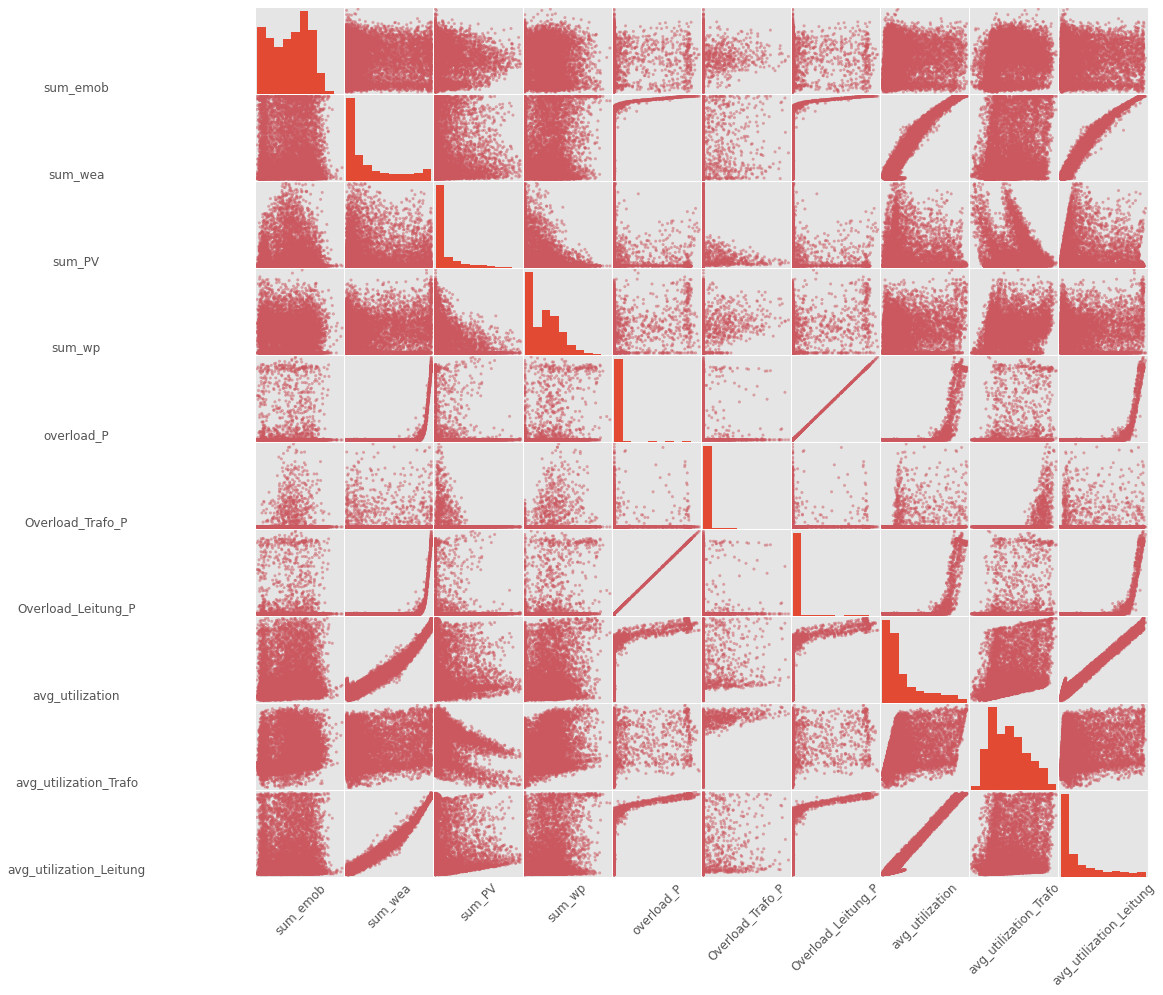

In [105]:

# dataset for correlation matrix for faster rendering, without the time values
df_scatter = df_small.drop(['NNF','year','month','day','hour','weekday','workhour'],axis=1)

scatter =scatter_matrix(df_scatter,
                        alpha=0.5,
                        figsize=(16,16),
                        color='#cb575f');

# change label rotation
[s.xaxis.label.set_rotation(45) for s in scatter.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in scatter.reshape(-1)]

# hide all ticks
[s.set_xticks(()) for s in scatter.reshape(-1)]
[s.set_yticks(()) for s in scatter.reshape(-1)]

# offset label to prevent overlap of figure
[s.get_yaxis().set_label_coords(-2,0) for s in scatter.reshape(-1)]

# print correlation matrix
df_scatter.corr()

#### XGBoost Feature Importance analysis

In [39]:
# create test and training dataset as well as validation set
train_end_idx = round(8760 * 0.8) 
valid_end_idx = round(8760 * 0.9) 
test_end_idx = 8760

df_small_train = df_small[:train_end_idx]
df_small_valid = df_small[train_end_idx : valid_end_idx]
df_small_test = df_small[valid_end_idx:]

print('Indices:',
      train_end_idx,
      valid_end_idx,
      test_end_idx)

print('\ndf_small_train has ' + str(len(df_small_train)) + ' rows.')
print('df_small_test has ' + str(len(df_small_valid)) + ' rows.')
print('df_small_valid has ' + str(len(df_small_test)) + ' rows.\n')

############### For overload_P ######################

## create training and test data: response y
#y_train = df_small_train['overload_P'].values
#y_valid = df_small_valid['overload_P'].values
#y_test = df_small_test['overload_P'].values
#
## reshape response y
#y_train = y_train.reshape(-1, 1)
#y_valid = y_valid.reshape(-1, 1)
#y_test = y_test.reshape(-1, 1)
#
## create training and test data: feature matrix X (without response and response forecast)
#X_train = df_small_train.drop(['overload_P', 'Overload_Leitung_P'], axis=1)
#X_test = df_small_test.drop(['overload_P', 'Overload_Leitung_P'], axis=1)
#X_valid = df_small_valid.drop(['overload_P', 'Overload_Leitung_P'], axis=1)


############### For avg_utilization ######################

# create training and test data: response y
y_train = df_small_train['avg_utilization'].values
y_valid = df_small_valid['avg_utilization'].values
y_test = df_small_test['avg_utilization'].values

# reshape response y
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# create training and test data: feature matrix X (without response and response forecast)
X_train = df_small_train.drop(['avg_utilization', 'avg_utilization_Leitung', 'avg_utilization_Trafo'], axis=1)
X_test = df_small_test.drop(['avg_utilization', 'avg_utilization_Leitung', 'avg_utilization_Trafo'], axis=1)
X_valid = df_small_valid.drop(['avg_utilization', 'avg_utilization_Leitung','avg_utilization_Trafo'], axis=1)

# get names of feature columns
names = X_train.columns.values

print(names,
      type(names))

Indices: 7008 7884 8760

df_small_train has 7008 rows.
df_small_test has 876 rows.
df_small_valid has 876 rows.

['NNF' 'year' 'month' 'day' 'hour' 'workhour' 'weekday' 'sum_emob'
 'sum_wea' 'sum_PV' 'sum_wp' 'overload_P' 'Overload_Trafo_P'
 'Overload_Leitung_P'] <class 'numpy.ndarray'>


In [50]:
################ Feature scaling: DEPENDS ON CLUSTERING TASK
#
# required: Definition of distance measures:
# Euclidian distance: Feature scaling: Standardization
# Correlation based distancce: MinMaxScaler

################ Find out distribution of data



import scipy.stats as st
def get_best_distribution(data):
    dist_names = ['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang']
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]



## define feature scalers
#scaler_price = MinMaxScaler(feature_range=(0, 1))
#scaler_mult = MinMaxScaler(feature_range=(0, 1))
#
## apply scaler to response vector
#scaler_price.fit(y_train)
#scaler_price.transform(y_train)
#scaler_price.transform(y_valid)
#scaler_price.transform(y_test)
#
## apply scaler to feature matrix
#scaler_mult.fit(X_train)
#scaler_mult.transform(X_train)
#scaler_mult.transform(X_valid)
#scaler_mult.transform(X_test)

In [117]:
######### initialize 1st XGBoost Model

param = {'eta': 0.01, 
         'max_depth': 1, 
         'subsample': 1.0, 
         'colsample_bytree': 0.80, 
         'alpha': 1.5, 
         'lambda': 1.5, 
         'gamma': 1.5,
         'objective': 'reg:squarederror', 
         'eval_metric': 'rmse', 
         'silent': 1, 
         'min_child_weight': 5, 
         'n_jobs': -1}

# create DMatrix object for training data
dtrain = xgb.DMatrix(X_train, 
                     y_train, 
                     feature_names = X_train.columns.values)

# create DMatrix object for validation data
dtest = xgb.DMatrix(X_valid, 
                    y_valid, 
                    feature_names = X_valid.columns.values)

eval_list = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(param, dtrain, 100, eval_list)


[0]	train-rmse:17.9726	eval-rmse:12.5737
[1]	train-rmse:17.806	eval-rmse:12.4495
[2]	train-rmse:17.6411	eval-rmse:12.3284
[3]	train-rmse:17.478	eval-rmse:12.2068
[4]	train-rmse:17.3166	eval-rmse:12.0883
[5]	train-rmse:17.1569	eval-rmse:11.9685
[6]	train-rmse:17.0096	eval-rmse:11.8471
[7]	train-rmse:16.853	eval-rmse:11.7324
[8]	train-rmse:16.6981	eval-rmse:11.6198
[9]	train-rmse:16.5449	eval-rmse:11.5049
[10]	train-rmse:16.3933	eval-rmse:11.3914
[11]	train-rmse:16.2432	eval-rmse:11.2824
[12]	train-rmse:16.0948	eval-rmse:11.1713
[13]	train-rmse:15.948	eval-rmse:11.065
[14]	train-rmse:15.8026	eval-rmse:10.9558
[15]	train-rmse:15.6679	eval-rmse:10.8459
[16]	train-rmse:15.5254	eval-rmse:10.7432
[17]	train-rmse:15.3844	eval-rmse:10.6417
[18]	train-rmse:15.2538	eval-rmse:10.5355
[19]	train-rmse:15.1155	eval-rmse:10.4318
[20]	train-rmse:14.9877	eval-rmse:10.3279
[21]	train-rmse:14.852	eval-rmse:10.2313
[22]	train-rmse:14.7179	eval-rmse:10.1355
[23]	train-rmse:14.5851	eval-rmse:10.0364
[24]	tra

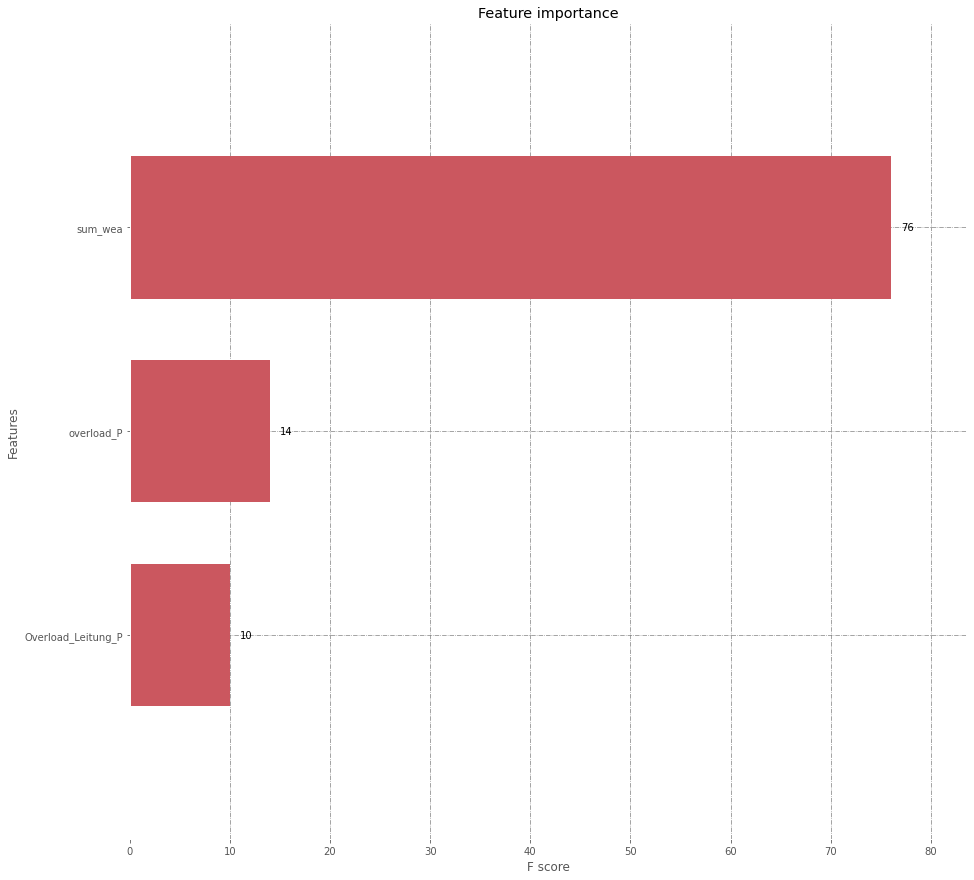

In [118]:
# plot the XGB importance values
fig_xgb, ax_xgb = plt.subplots(figsize=(15, 15))
xgb.plot_importance(xgb_model, max_num_features=70, height=0.7, ax=ax_xgb, color='#cb575f')

# design plotting area
ax_xgb.set_facecolor('white')
ax_xgb.grid(color='grey', linestyle='-.', linewidth=0.7)
plt.show()

In [119]:
######### initialize 2nd XGBoost Model

param = {'eta': 0.05, 
         'max_depth': 2, 
         'subsample': 1.0, 
         'colsample_bytree': 0.80, 
         'alpha': 1.5, 
         'lambda': 1.5, 
         'gamma': 1.5,
         'objective': 'reg:linear', 
         'eval_metric': 'rmse', 
         'silent': 1, 
         'min_child_weight': 5, 
         'n_jobs': -1}

# create DMatrix object for training data
dtrain = xgb.DMatrix(X_train, 
                     y_train, 
                     feature_names = X_train.columns.values)

# create DMatrix object for validation data
dtest = xgb.DMatrix(X_valid, 
                    y_valid, 
                    feature_names = X_valid.columns.values)
eval_list = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model2 = xgb.train(param, dtrain, 100, eval_list)




[0]	train-rmse:17.2609	eval-rmse:12.1098
[1]	train-rmse:16.4257	eval-rmse:11.5499
[2]	train-rmse:15.6329	eval-rmse:11.0215
[3]	train-rmse:14.8802	eval-rmse:10.5189
[4]	train-rmse:14.1658	eval-rmse:10.0441
[5]	train-rmse:13.487	eval-rmse:9.58974
[6]	train-rmse:12.9022	eval-rmse:9.10326
[7]	train-rmse:12.2867	eval-rmse:8.70039
[8]	train-rmse:11.7026	eval-rmse:8.31678
[9]	train-rmse:11.1495	eval-rmse:7.9597
[10]	train-rmse:10.6242	eval-rmse:7.61744
[11]	train-rmse:10.1236	eval-rmse:7.29551
[12]	train-rmse:9.65024	eval-rmse:6.96873
[13]	train-rmse:9.199	eval-rmse:6.68054
[14]	train-rmse:8.77269	eval-rmse:6.4122
[15]	train-rmse:8.40463	eval-rmse:6.10863
[16]	train-rmse:8.01646	eval-rmse:5.84466
[17]	train-rmse:7.65024	eval-rmse:5.61669
[18]	train-rmse:7.33647	eval-rmse:5.36366
[19]	train-rmse:7.00288	eval-rmse:5.14372
[20]	train-rmse:6.72255	eval-rmse:4.92043
[21]	train-rmse:6.42107	eval-rmse:4.7253
[22]	train-rmse:6.13559	eval-rmse:4.54008
[23]	train-rmse:5.86674	eval-rmse:4.38743
[24]	tra

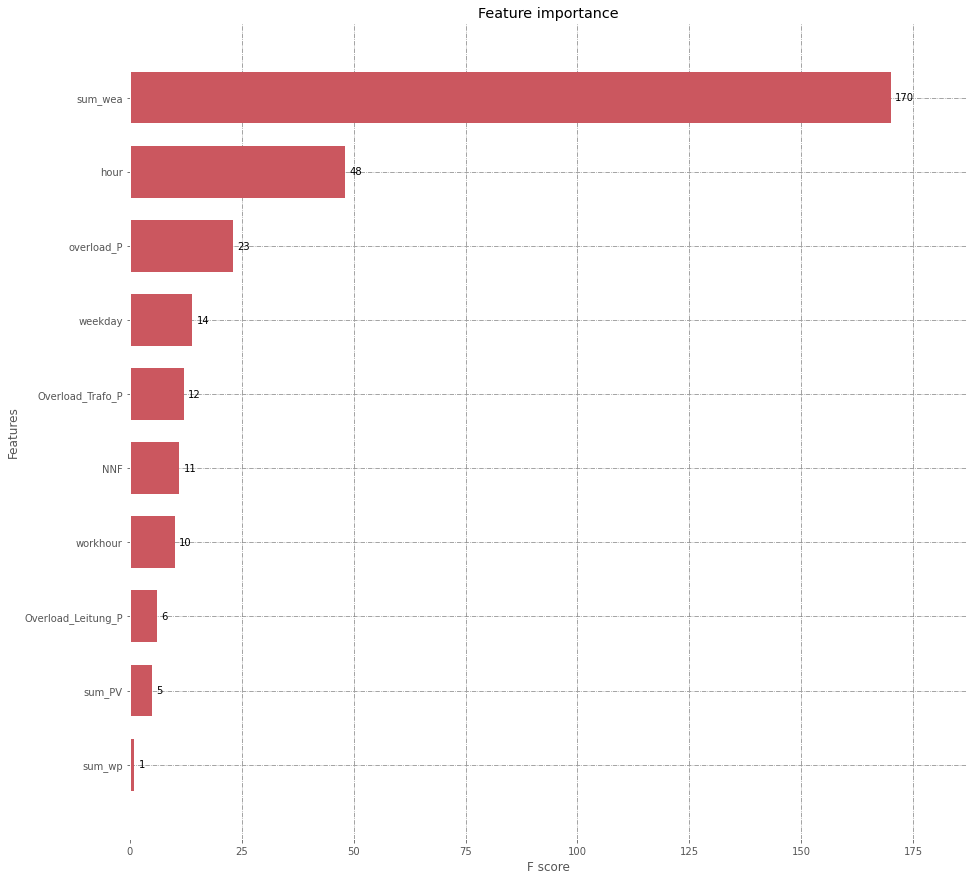

In [120]:
# plot the XGB importance values
fig_xgb, ax_xgb = plt.subplots(figsize=(15, 15))
xgb.plot_importance(xgb_model2, max_num_features=70, height=0.7, ax=ax_xgb, color='#cb575f')

# design plotting area
ax_xgb.set_facecolor('white')
ax_xgb.grid(color='grey', linestyle='-.', linewidth=0.7)
plt.show()

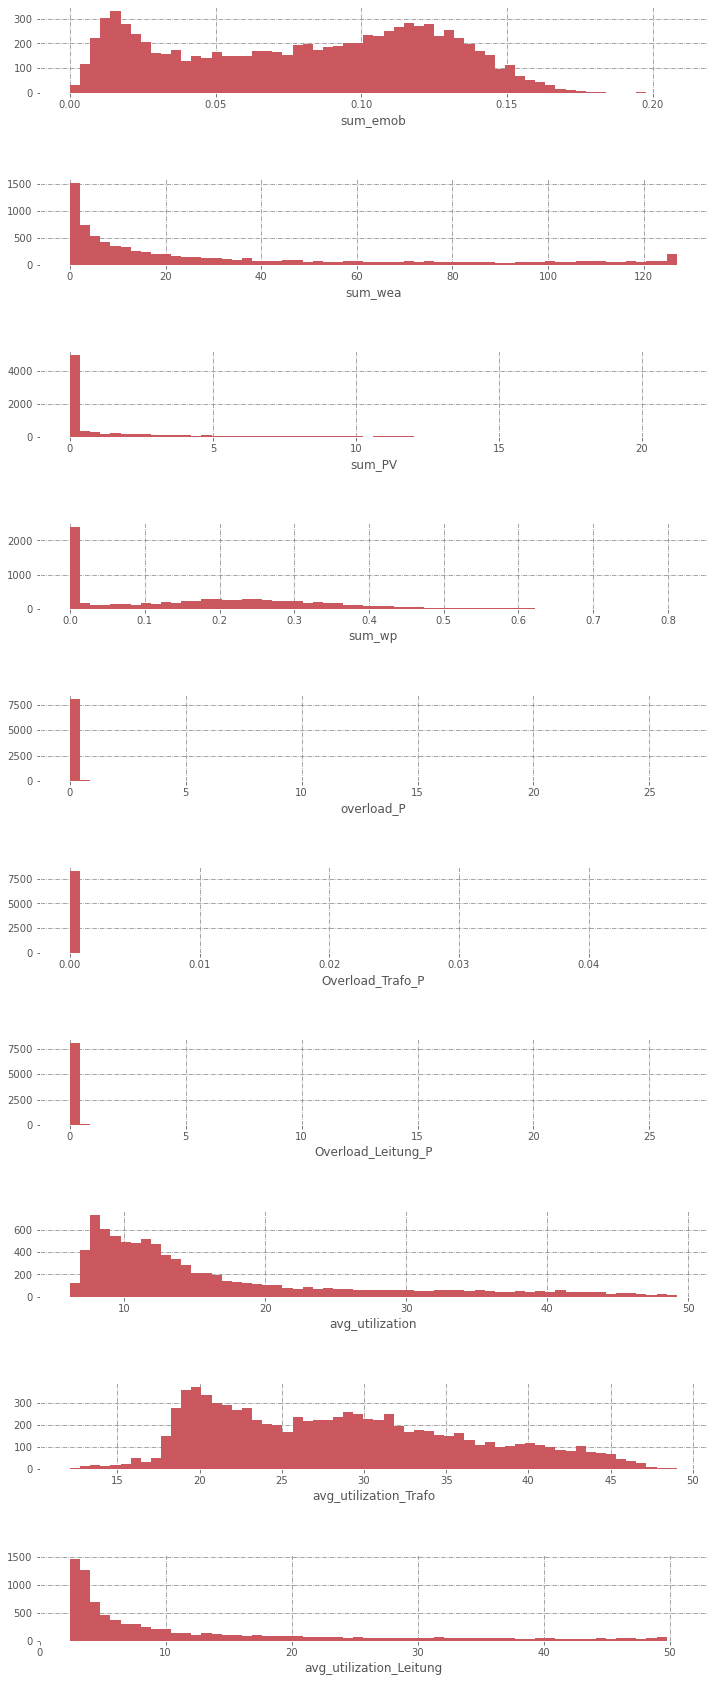

sum_emob


C:\Users\laumen\.conda\envs\willem\lib\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Best fitting distribution: exponweib
Best p value: 2.2786422683400427e-19
Parameters for the best fit: (0.13522945914375895, 8.35860151750772, -3.534813833893702e-05, 0.14717148625182397)


sum_wea


C:\Users\laumen\.conda\envs\willem\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


Best fitting distribution: exponweib
Best p value: 3.6130947994465636e-55
Parameters for the best fit: (0.7649747376196561, 0.8021057762723623, -4.783627793626168e-29, 47.13003187443847)


sum_PV


C:\Users\laumen\.conda\envs\willem\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Best fitting distribution: pareto
Best p value: 2.1871121187549293e-298
Parameters for the best fit: (0.14621546035413246, -8.43837524917223e-05, 1.88176122446839e-05)


sum_wp
Best fitting distribution: norm
Best p value: 2.3202010106840078e-125
Parameters for the best fit: (0.1776483904109589, 0.1557165076595388)


overload_P
Best fitting distribution: norm
Best p value: 0.0
Parameters for the best fit: (0.8601326404365706, 3.7673617535175796)


Overload_Trafo_P
Best fitting distribution: norm
Best p value: 0.0
Parameters for the best fit: (0.0007342639449563776, 0.0038327241936693766)


Overload_Leitung_P
Best fitting distribution: norm
Best p value: 0.0
Parameters for the best fit: (0.8593983764916141, 3.767095125350733)


avg_utilization
Best fitting distribution: gamma
Best p value: 1.2441977076786422e-48
Parameters for the best fit: (1.2171101046869373, 6.142953985643773, 8.638265334302513)


avg_utilization_Trafo
Best fitting distribution: gamma
Best p value: 3.685230119351197e

In [139]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", 
                  'gamma', 'beta', 'rayleigh', 'norm', 'pareto']
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        #print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

###########################################################

# Find AND print AND plot best fit distribution
matplotlib.style.use('ggplot')

fig, ax  = plt.subplots(figsize=(10, 40))   

# plot histogram of all features
datalist = df_small.values
fig.tight_layout()
plt.subplots_adjust(left=None, 
                bottom=None, 
                right=None, 
                top=None, 
                wspace=1, 
                hspace=1)

for column in range(7,datalist.shape[1]):
    ax = plt.subplot(datalist.shape[1], 1, column+1)
    ax.set_facecolor('white')
    ax.set_xlabel(df_small.columns[column], fontsize=12)
    ax.grid(color='grey', linestyle='-.', linewidth=0.7)
    plt.hist(datalist[:, column], bins=60, color='#cb575f')         
plt.show()


# calculate and display best fitting distributions
for column in df_small.drop(['NNF','year','month','day','hour','weekday','workhour'], axis=1): 
    # Select column contents by column name using [] operator
    print(column)
    data = df_small[column]
    best_fit_name, best_fit_params , params = get_best_distribution(data)
    best_dist = getattr(st, best_fit_name)
    print('\n')
   
          
#best_fit_name, best_fit_params = get_best_distribution(data)
#best_dist = getattr(st, best_fit_name)


